# 第３回講義 演習

## 課題. k-Nearest Neighbors (k-NN) を使った手書き文字認識

In [1]:
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata

import numpy as np
import matplotlib.pyplot as plt

### 1. MNISTデータセットの読み込み

fetch_mldataで参照するmldata.orgが死んでいるので、代わりのMNISTを読み込む。
参考 https://github.com/ageron/handson-ml/issues/7

In [31]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [39]:
#mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist["data"], mnist["target"], random_state=42)

mnist_X = mnist_X / 255.0

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y,
                                                    test_size=0.2,
                                                    random_state=42)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.2,
                                                      random_state=42)

### 2. MNISTデータの可視化

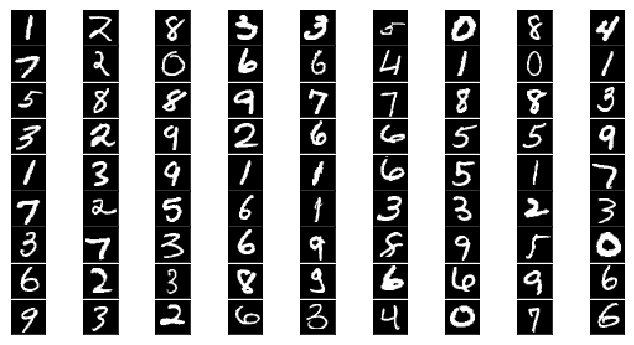

In [43]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(train_X[i].reshape((28, 28)), cmap='gray')

### 3. 精度評価について [[リンク](http://ibisforest.org/index.php?F%E5%80%A4)]

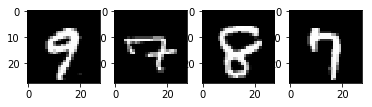

In [45]:
import sklearn
imgs = list(map(lambda x: x.reshape(28, 28), sklearn.utils.shuffle(mnist["data"])))

row, col = 1, 4

fig = plt.figure()
for i in range(row*col):
    sp = fig.add_subplot(row, col, i+1)  
    sp.imshow(imgs[i], cmap='gray', interpolation='none')
plt.show()

||**実際が正例**|**実際が負例**|
|:---------:|:---------:|:---------:|
|**予測が正例**|True Positive (TP)|False Positive (FP)|
|**予測が負例**|False Negative (FN)|True Negative (TN)|

- 正解率 (Accuracy): 全データのうち, 予測が当たったものの割合
    $$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{FN} + \text{TN}} $$
- 適合率 (Precision): 正と予測したデータのうち, 実際に正であるものの割合
    $$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
- 再現率 (Recall): 実際に正であるもののうち, 正であると予測されたものの割合
    $$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
- F値 (F-measure): 精度と再現率の調和平均
    $$ \text{F-measure} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

### 4. 距離関数について

#### Cosine類似度

$$ cos \left({\bf a},{\bf b}\right) = \frac{{\bf a}\cdot{\bf b}}{\|{\bf a}\| \|{\bf b}\|} = \frac{\sum^{n}_{i} a_i b_i}{\sqrt{\sum^{n}_{i} a^2_i} \sqrt{\sum^{n}_{i} b^2_i}} $$

ここから自分の解釈
$$ 
\|{\bf a}\| \|{\bf b}\| cos \left({\bf a},{\bf b}\right) = {\bf a}\cdot{\bf b}
$$
としてみると、これは高校のときに習った内積の公式と何ら変わりない。内積は2つの矢印があったときに、その一方にもう一方を射影して、長さ分掛け算したものだった。cosineだけが残るように正規化したcosine類似度は、ベクトルの向きが似ているか考慮しているといえる。原点から見て、${\bf a}, {\bf b}$が同一直線上にいれば、点が重なっていなくても類似度は最大1or最小-1となるわけだ。


In [46]:
# 分母に当たるノルムを計算
norm = np.linalg.norm(train_X, ord=2, axis=1)
normalized_train_X = train_X / norm[:, np.newaxis]

sample_1 = normalized_train_X[0]
sample_2 = normalized_train_X[1]
print(np.dot(sample_1, sample_2))

0.2776348795242644
